In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.conv_learner import *
from fastai.plots import *
from sklearn.metrics import fbeta_score as f2

In [3]:
PATH = "/storage/data/planets/"

In [4]:
!ls {PATH}

__MACOSX     test-tif-v2.tar	       train-jpg.tar	 train-tif-v2.tar
test-jpg     test_v2_file_mapping.csv  train-jpg.tar.7z  train_v2.csv
test-tif-v2  train-jpg		       train-tif-v2


## Multi-label versus single-label classification

In [8]:
def get_lst(path): return glob(f'{path}/*.*')[0]

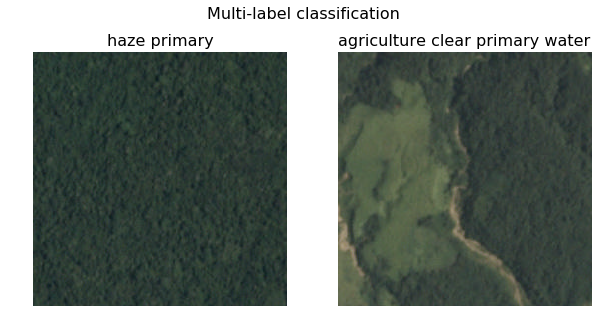

In [9]:
list_paths = [f"{PATH}train-jpg/train_10007.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [10]:
metrics = [f2]
f_model = resnet34

In [12]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [13]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, suffix='.jpg',
                                        val_idxs=val_idxs, test_name='test-jpg')

In [14]:
data = get_data(256)

- Multi-label classification cannot be done with Keras style approach where subfolder is the name of the label. So we use from_csv
- transform_top_down : it does more than just a vertical flip. There are 8 possible symmetries for a square — it can be rotated through 0, 90, 180, 270 degrees and for each of those, it can be flipped (dihedral group of eight)

In [15]:
x,y = next(iter(data.val_dl))

- We had seen data.val_ds , test_ds, train_ds(ds: dataset) for which you can get an individual image by data.train_ds[0], for example.
- dl is a data loader which will give you a mini-batch, specifically transformed mini-batch. With a data loader, you cannot ask for a particular mini-batch; you can only get back the next mini-batch. In Python, it is called “generator” or “iterator”. PyTorch really leverages modern Python methodologies.

In [16]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

- `x` : a mini-batch of images, 
- `y` : a mini-batch of labels.

In [17]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

Behind the scenes, PyTorch and fast.ai are turning our labels into one-hot-encoded labels.

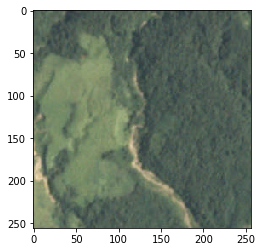

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

- *1.4 : The image was washed out, so making it more visible (“brightening it up a bit”). Images are just matrices of numbers, so we can do things like this.
- It is good to experiment images like this because these images are not at all like ImageNet. The vast majority of things you do involving convolutional neural net will not actually be anything like ImageNet (medical imaging, classifying different kinds of steel tube, satellite images, etc)

In [19]:
sz=64

data = get_data(sz)
data = data.resize(int(sz*1.3), 'tmp')

- We will not use sz=64 for cats and dogs competition because we started with pre-trained ImageNet network which starts off nearly perfect. If we re-trained the whole set with 64 by 64 images, we would destroy the weights that are already very good. Remember, most of ImageNet models are trained with 224 by 224 or 299 by 299 images.

- There is no images in ImageNet that looks like the one above. And only the first couple layers are useful to us. So starting out with smaller images works well in this case.

In [25]:
f = lambda x, y: f2(x, y, 0.5)
metrics = [f]

In [30]:
learn = ConvLearner.pretrained(f_model, data)

epoch      trn_loss   val_loss   <lambda>   
    0      0.223931   0.267402   0.927116  


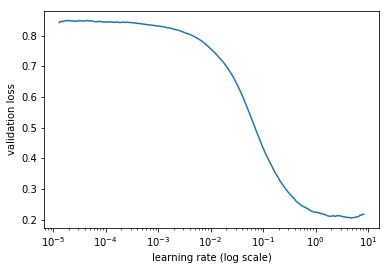

In [31]:
lrf = learn.lr_find()
learn.sched.plot()

In [32]:
lr = 0.2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>   
    0      0.147589   0.132702   0.948414  
    1      0.144247   0.126879   0.950318  
    2      0.141072   0.125355   0.951248  
    3      0.138077   0.124602   0.950732  
    4      0.132436   0.122833   0.951742  
    5      0.132914   0.121246   0.95268   
    6      0.12959    0.121128   0.952752  


[array([0.12113]), 0.9527522450910076]

In [34]:
lrs = np.array([lr/9,lr/3,lr])

In [35]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>   
    0      0.121178   0.10963    0.95709   
    1      0.117706   0.107231   0.957991  
    2      0.10929    0.101293   0.960658  
    3      0.110991   0.104064   0.959568  
    4      0.106689   0.098125   0.962024  
    5      0.100051   0.097924   0.961865  
    6      0.100113   0.09611    0.962889  


[array([0.09611]), 0.9628892190446082]

In [36]:
learn.save(f'{sz}')

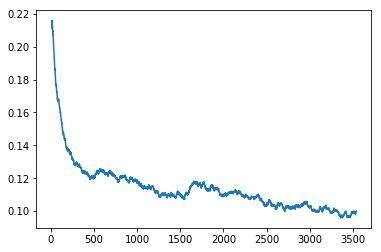

In [37]:
learn.sched.plot_loss()

#### Increase batch size to 128

In [38]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>   
    0      0.098706   0.093772   0.963289  
 24%|██▎       | 120/506 [00:10<00:33, 11.42it/s, loss=0.1]

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

#### Increase batch size to 256

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

### Predict the result

In [ ]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
f2(preds, y, 0.5)